<a href="https://colab.research.google.com/github/vloneonme/trew/blob/main/vipsa_lr7_vpkna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install ucimlrepo


In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
#print(cdc_diabetes_health_indicators.metadata)

# variable information
#print(cdc_diabetes_health_indicators.variables)
X

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,18,0,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,1,28,0,0,0,1,1,0,...,1,0,1,0,0,0,0,2,5,2
253678,1,0,1,23,0,0,0,0,1,1,...,1,0,3,0,0,0,1,7,5,1


In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, confusion_matrix




ARI (K-Means): 0.1538764254599585
Confusion matrix:
[[168139  50195]
 [ 14590  20756]]


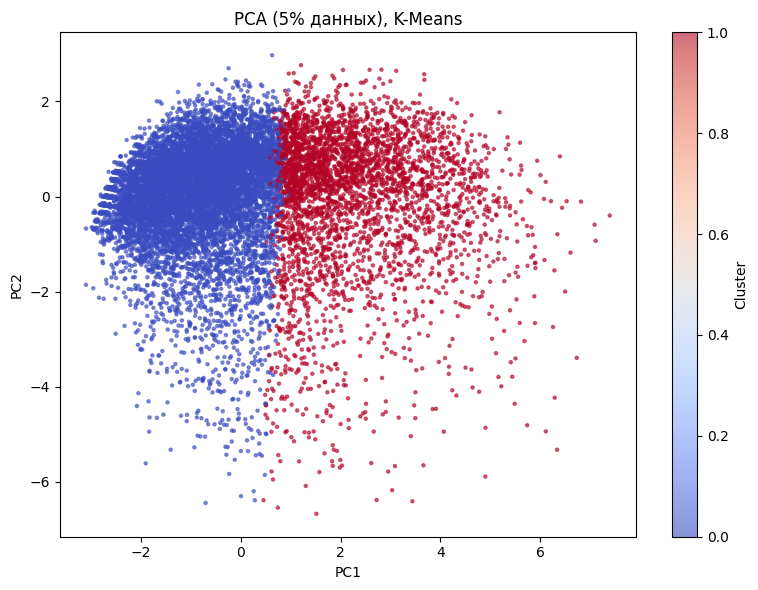

In [3]:
# ============================================
# КЛАСТЕРИЗАЦИЯ И ВИЗУАЛИЗАЦИЯ ДАННЫХ О ДИАБЕТЕ
# K-Means (все данные) + Ward (подвыборка)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA

# --------------------------------------------
# 1. Загрузка данных
# --------------------------------------------
cdc = fetch_ucirepo(id=891)
X = cdc.data.features.copy()
y_true = cdc.data.targets["Diabetes_binary"]

# --------------------------------------------
# 2. Feature Engineering
# --------------------------------------------
X["CardioRisk"] = X["HighBP"] + X["HighChol"] + X["HeartDiseaseorAttack"] + X["Stroke"]
X["LifestyleRisk"] = X["Smoker"] + X["HvyAlcoholConsump"] - X["PhysActivity"]
X["DietScore"] = X["Fruits"] + X["Veggies"]
X["HealthBurden"] = X["PhysHlth"] + X["MentHlth"]

X.drop(columns=[
    "HighBP", "HighChol", "HeartDiseaseorAttack", "Stroke",
    "Smoker", "HvyAlcoholConsump", "PhysActivity",
    "Fruits", "Veggies", "PhysHlth", "MentHlth"
], inplace=True)

# --------------------------------------------
# 3. Масштабирование
# --------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------
# 4. K-Means (ВСЕ ДАННЫЕ)
# --------------------------------------------
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# --------------------------------------------
# 5. Оценка качества
# --------------------------------------------
print("ARI (K-Means):", adjusted_rand_score(y_true, clusters))
print("Confusion matrix:")
print(confusion_matrix(y_true, clusters))

# --------------------------------------------
# 6. Подвыборка для визуализации (5%)
# --------------------------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for _, idx in split.split(X_scaled, y_true):
    X_vis = X_scaled[idx]
    clusters_vis = clusters[idx]

# --------------------------------------------
# 7. PCA
# --------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_vis)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters_vis,
    s=5,
    alpha=0.6,
    cmap="coolwarm"
)
plt.title("PCA (5% данных), K-Means")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()


ARI (MiniBatchKMeans): 0.13187396788717567
Confusion matrix:
[[157119  61215]
 [ 11633  23713]]


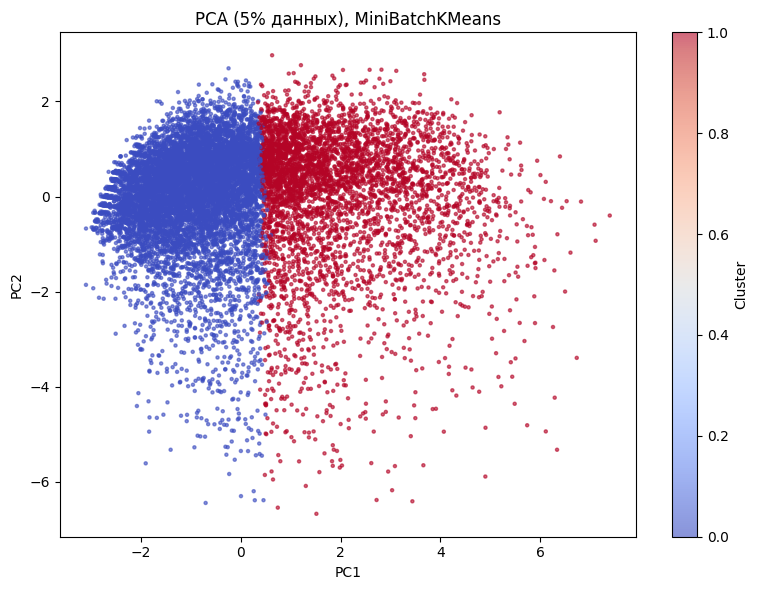

In [4]:
# ============================================
# КЛАСТЕРИЗАЦИЯ ДАННЫХ О ДИАБЕТЕ
# Метод: MiniBatchKMeans (k = 2)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA

# --------------------------------------------
# 1. Загрузка данных
# --------------------------------------------
cdc = fetch_ucirepo(id=891)
X = cdc.data.features.copy()
y_true = cdc.data.targets["Diabetes_binary"]

# --------------------------------------------
# 2. Feature Engineering
# --------------------------------------------
X["CardioRisk"] = (
    X["HighBP"] +
    X["HighChol"] +
    X["HeartDiseaseorAttack"] +
    X["Stroke"]
)

X["LifestyleRisk"] = (
    X["Smoker"] +
    X["HvyAlcoholConsump"] -
    X["PhysActivity"]
)

X["DietScore"] = X["Fruits"] + X["Veggies"]

X["HealthBurden"] = X["PhysHlth"] + X["MentHlth"]

X.drop(columns=[
    "HighBP", "HighChol", "HeartDiseaseorAttack", "Stroke",
    "Smoker", "HvyAlcoholConsump", "PhysActivity",
    "Fruits", "Veggies",
    "PhysHlth", "MentHlth"
], inplace=True)

# --------------------------------------------
# 3. Масштабирование
# --------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------
# 4. MiniBatchKMeans
# --------------------------------------------
kmeans = MiniBatchKMeans(
    n_clusters=2,
    batch_size=5000,
    max_iter=100,
    n_init=10,
    random_state=42
)

clusters = kmeans.fit_predict(X_scaled)

# --------------------------------------------
# 5. Оценка качества
# --------------------------------------------
print("ARI (MiniBatchKMeans):", adjusted_rand_score(y_true, clusters))
print("Confusion matrix:")
print(confusion_matrix(y_true, clusters))

# --------------------------------------------
# 6. Стратифицированная подвыборка (5%)
# --------------------------------------------
split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.05,
    random_state=42
)

for _, idx in split.split(X_scaled, y_true):
    X_vis = X_scaled[idx]
    clusters_vis = clusters[idx]

# --------------------------------------------
# 7. PCA для визуализации
# --------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_vis)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters_vis,
    s=5,
    alpha=0.6,
    cmap="coolwarm"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (5% данных), MiniBatchKMeans")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()
